## Notebook to bulk download Planet imagery through the API
Rainey Aberle, Fall 2021

Modified from [Planet Developers API Tutorial](https://developers.planet.com/docs/apis/data/) and Planet Labs GitHub Repository: [planetlabs/notebooks/jupyter-notebooks/orders/](https://github.com/planetlabs/notebooks/tree/master/jupyter-notebooks/orders)


__To-Do:__
- View image footprints before downloading. Will need to download only the metadata first, then plot the coordinates over a regional map. 
- Implement percent AOI coverage filter for image search

### Import necessary packages

In [2]:
import os
import json
import requests
import time
import geopandas as gpd
from pathlib import Path
import rasterio as rio
import numpy as np
from rasterio.plot import show
from requests.auth import HTTPBasicAuth

### Install Planet API Client

This will allow you to interact with the Planet API through this notebook. Refer to the __[Planet API documentation](https://developers.planet.com/docs/apis/data/)__ for more info. 

In [3]:
!pip3 install planet

### Define filters for image search
#### _Modify these sections_

In [4]:
# ----------Area of Interest (AOI)----------
#### OPTION 1: Use geojson.io to create a polygon
#    - Type geojson.io into a new browser page
#    - Draw a RECTANGULAR polygon over your AOI  
#    - Copy only the geometry below
# AOI_box = {
#         "type": "Polygon",
#         "coordinates": [
#           [
#             [
#               -148.96774291992188,
#               60.366355109034046
#             ],
#             [
#               -148.84963989257812,
#               60.366355109034046
#             ],
#             [
#               -148.84963989257812,
#               60.440285056170616
#             ],
#             [
#               -148.96774291992188,
#               60.440285056170616
#             ],
#             [
#               -148.96774291992188,
#               60.366355109034046
#             ]
#           ]
#         ]
#       }
# AOI_box

In [5]:
#### OPTION 2: Import an existing shapefile

# Name of your file
# If your shapefile is not currently in this directory, you need to include the full file path in 'file_name' below
file_name = 'inputs/wolverineGlacier.shp'

# Read in the shapefile
AOI = gpd.read_file(file_name)

# File extension index (we don't want the .shp extension in the next line)
i = file_name.index('.shp')

# Convert to geojson
AOI.to_file(file_name[0:i]+'.geojson', driver='GeoJSON')

# Adjust AOI polygon to a rectangular shape 
# Planet only excepts a bounding BOX as a spatial filter, 
# so we need to convert our AOI to a box (if it is not already). 
AOI_box = {"type": "Polygon",
           "coordinates": [[
               [AOI.bounds.minx[0],AOI.bounds.miny[0]],
               [AOI.bounds.maxx[0],AOI.bounds.miny[0]],
               [AOI.bounds.maxx[0],AOI.bounds.maxy[0]],
               [AOI.bounds.minx[0],AOI.bounds.maxy[0]],
               [AOI.bounds.minx[0],AOI.bounds.miny[0]]
           ]]
          }
AOI_box

{'type': 'Polygon',
 'coordinates': [[[-148.95326841198016, 60.371302662734315],
   [-148.86179281085342, 60.371302662734315],
   [-148.86179281085342, 60.440369811236046],
   [-148.95326841198016, 60.440369811236046],
   [-148.95326841198016, 60.371302662734315]]]}

In [4]:
# ----------AOI clipping----------
# Would you like to clip images to the AOI (True/False)?
# This greatly speeds up the ordering and downloading process.
clip_AOI = True

# ----------Date Range----------
# Format: 'YYYY-MM-DD'
start_date = "2021-10-01"
end_date = "2021-10-10"

# ----------Cloud Filter----------
# Format: decimal (e.g., 50% max cloud cover = 0.5)
max_cloud_cover = 0.2

# ----------Item Type----------
# See here for possible image ("item") types:
# https://developers.planet.com/docs/apis/data/items-assets/
item_type = "PSScene4Band"

# ----------Planet API Key----------
# Find your API key on your Planet Account: account.planet.com
# My Settings > API Key
API_key = '21d92c1c372146c089f0182295d3b028'

# ----------Output folder----------
# AKA, where you want your images to be downloaded in your directory
out_folder = '/Users/raineyaberle/Desktop/Research/PhD/Wolverine/images/'

---------------------
### Authentication via basic HTTP

In [5]:
# set API key as environment variable
os.environ['PL_API_KEY'] = API_key

# Setup the API Key stored as the `PL_API_KEY` environment variable
PLANET_API_KEY = os.getenv('PL_API_KEY')

# Orders URL
orders_url = 'https://api.planet.com/compute/ops/orders/v2'

# Authorize
auth = HTTPBasicAuth(PLANET_API_KEY, '')
response = requests.get(orders_url, auth=auth)
response

<Response [200]>

### Compile filters and use Quick Search to grab image IDs

In [6]:
# get images that overlap with our AOI 
geometry_filter = {
  "type": "GeometryFilter",
  "field_name": "geometry",
  "config": AOI_box
}

# get images acquired within a date range
date_range_filter = {
  "type": "DateRangeFilter",
  "field_name": "acquired",
  "config": {
    "gte": start_date + "T00:00:00.000Z",
    "lte": end_date + "T00:00:00.000Z"
  }
}

# only get images which have <50% cloud coverage
cloud_cover_filter = {
  "type": "RangeFilter",
  "field_name": "cloud_cover",
  "config": {
    "lte": max_cloud_cover
  }
}

# combine our geo, date, cloud filters
combined_filter = {
  "type": "AndFilter",
  "config": [geometry_filter, date_range_filter, cloud_cover_filter]
}

# define the clip tool
clip = {
    "clip": {
        "aoi": AOI_box
    }
}

# API request object
QS_request = {
  #"interval":"day",
  "item_types":[item_type], 
  "filter":combined_filter,
}

# fire off the POST request
QS_result = \
  requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(PLANET_API_KEY, ''),
    json=QS_request)

# Print resulting image IDs
im_ids = [feature['id'] for feature in QS_result.json()['features']]
print(im_ids)

['20211007_202318_88_245c', '20211004_202442_51_2434', '20211004_202440_21_2434', '20211004_202214_68_2223', '20211004_202212_47_2223', '20211004_202012_13_2427']


### Place Order

In [7]:
# set content type to json
headers = {'content-type': 'application/json'}

# create a request object
# (clip images if clip==True)
if clip_AOI:
    request = {  
       "name":"simple order",
       "products":[
          {
              "item_ids": im_ids,
              "item_type": item_type,
              "product_bundle":"analytic"
          }
       ],
        "tools": [clip]
    }
else:
    request = {  
       "name":"simple order",
       "products":[
          {
              "item_ids": im_ids,
              "item_type": item_type,
              "product_bundle":"analytic"
          }
       ],
    }

# define function to place order
def place_order(search_request, auth):
    response = requests.post(orders_url, data=json.dumps(search_request), auth=auth, headers=headers)
    print(response)
    order_id = response.json()['id']
    print(order_id)
    order_url = orders_url + '/' + order_id
    return order_url

# place order
order_url = place_order(request, auth)

<Response [202]>
a58eac2e-c15c-4cae-bc0a-5af4eafaf051


### Poll for Order Success
- This section outputs the status of the order every ~10 sec. This will take a few minutes... 
- Wait until it outputs `success` to proceed to the next section. It will stop after 30 loops, so try proceeding to the next section if it finishes running and does not output `success`.
- If you are ordering a LOT of images, consider narrowing your date range to download less images at a time. 

In [8]:
def poll_for_success(order_url, auth, num_loops=30):
    count = 0
    while(count < num_loops):
        count += 1
        r = requests.get(order_url, auth=auth)
        response = r.json()
        state = response['state']
        print(state)
        end_states = ['success', 'failed', 'partial']
        if state in end_states:
            break
        time.sleep(10)
        
poll_for_success(order_url, auth)

running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
success


### View Results

In [9]:
r = requests.get(order_url, auth=auth)
response = r.json()
results = response['_links']['results']

[r['name'] for r in results]

['a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202442_51_2434_3B_AnalyticMS_DN_udm_clip.tif',
 'a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202442_51_2434_metadata.json',
 'a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202442_51_2434_3B_AnalyticMS_clip.tif',
 'a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202442_51_2434_3B_AnalyticMS_metadata_clip.xml',
 'a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202012_13_2427_3B_AnalyticMS_clip.tif',
 'a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202012_13_2427_metadata.json',
 'a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202012_13_2427_3B_AnalyticMS_metadata_clip.xml',
 'a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202012_13_2427_3B_AnalyticMS_DN_udm_clip.tif',
 'a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202214_68_2223_3B_AnalyticMS_clip.tif',
 'a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202214_68_2223_3

### Download each asset individually

In [10]:
# define function to download results
def download_results(results, overwrite=False):
    results_urls = [r['location'] for r in results]
    results_names = [r['name'] for r in results]
    print('{} items to download'.format(len(results_urls)))
    
    for url, name in zip(results_urls, results_names):
        path = Path(os.path.join(out_folder,name)) #pathlib.Path(os.path.join('data', name))
        
        if overwrite or not path.exists():
            print('downloading {} to {}'.format(name, path))
            r = requests.get(url, allow_redirects=True)
            path.parent.mkdir(parents=True, exist_ok=True)
            open(path, 'wb').write(r.content)
        else:
            print('{} already exists, skipping {}'.format(path, name))
            
# download images!
download_results(results)

25 items to download
downloading a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202442_51_2434_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Desktop/Research/PhD/planet_download/wolverine_images/a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202442_51_2434_3B_AnalyticMS_DN_udm_clip.tif
downloading a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202442_51_2434_metadata.json to /Users/raineyaberle/Desktop/Research/PhD/planet_download/wolverine_images/a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202442_51_2434_metadata.json
downloading a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202442_51_2434_3B_AnalyticMS_clip.tif to /Users/raineyaberle/Desktop/Research/PhD/planet_download/wolverine_images/a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202442_51_2434_3B_AnalyticMS_clip.tif
downloading a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211004_202442_51_2434_3B_AnalyticMS_metadata_clip.xml to /Users/rainey

### Visualize downloaded images

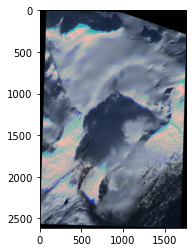

In [13]:
# define helpful functions for visualizing downloaded imagery
def show_rgb(img_file):
    with rio.open(img_file) as src:
        b,g,r,n = src.read()

    rgb = np.stack((r,g,b), axis=0)
    show(rgb/rgb.max())
    
def show_gray(img_file):
    with rio.open(img_file) as src:
        g = src.read(1)
    show(g/g.max())
    
# Replace this path with your image file path
img_file = out_folder+'a58eac2e-c15c-4cae-bc0a-5af4eafaf051/PSScene4Band/20211007_202318_88_245c_3B_AnalyticMS_clip.tif'
show_rgb(img_file)

## You did it!

<div>
<img src="sandy-cheeks.jpeg" width="400"/>
</div>